<a href="https://colab.research.google.com/github/Tonnonssi/MNISTCUSTOM-CNN-Classifier/blob/master/04.Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 00 Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from skimage.transform import rotate
from PIL import Image, ImageFilter

# 01 Classes and Functions

## Load data __ open_pickle function

In [ ]:
def open_pickle(file_loc):
    with open(file_loc,'rb') as f:
        while True:
            try:
                data = pickle.load(f)
            except EOFError:
                break
    return data

## Data preprocessing __ match_dtype function

In [ ]:
def match_dtype(data):
    img, label = data

    if img.dtype == 'float64':
        img = (img*255).astype(np.uint8)

    return (img, label)

## Augmentation __ class ZoomAgumentor
1. `np.where` 로 np.array인 이미지의 영역을 인식(min, max를 이용)
2. `np.crop()`으로 이미지를 자름
3. 이미지를 PIL.Image 타입으로 변환 후, `img.resize()` 매서드를 이용해 가로 세로 중 더 긴 부분을 28에 맞추어 확대
4. np.array로 이미지 타입을 바꾸고, 나머지 빈 공간을 `np.pad`을 이용해 28x28로 패딩

In [ ]:
class ZoomAugmentor:
    def __init__(self, data):
        self.np_img, self.label = data

        self.np_img = np.squeeze(self.np_img) # (1,28,28) -> (28,28)
        self.pil_img = Image.fromarray(self.np_img)

    def run(self):
        area_box = self.find_area_box(self.np_img)
        padded_box = self.padding(area_box=area_box)

        self.cropped_img = self.pil_img.crop(box=padded_box)
        self.zoomed_img = self.zoom_cropped_img(self.cropped_img)
        self.np_zoomed_img = np.array(self.zoomed_img)

        self.final_img = self.pad_to_28x28(self.np_zoomed_img)
        self.final_img = np.expand_dims(self.final_img, axis=2) #(28, 28) -> (28,28,1)

    def find_area_box(self, img):
        self.location = np.where(img != 0)
        self.upper, self.lower = min(self.location[0]), max(self.location[0])
        self.left, self.right = min(self.location[1]), max(self.location[1])
        return (self.left, self.upper, self.right, self.lower) # left, upper, right, lower

    def padding(self, area_box):
        left, upper, right, lower = area_box
        if left > 1:
            left -= 2
        if right < 26:
            right += 2
        if lower < 26:
            lower += 2
        if upper > 1:
            upper -= 2
        return (left, upper, right, lower)

    def zoom_cropped_img(self, img):
        self.width, self.height = (self.right - self.left + 1), (self.lower - self.upper + 1)

        if self.width > self.height:
            width_ratio = 28 / self.width

            zoomed_img = img.resize((round(width_ratio*self.width),
                                     round(width_ratio*self.height)),
                                     resample=Image.LANCZOS)
        else:
            height_ratio = 28 / self.height
            zoomed_img = img.resize((round(height_ratio*self.width),
                                     round(height_ratio*self.height)),
                                     resample=Image.LANCZOS)  #BICUBIC
        return zoomed_img

    def pad_to_28x28(self, img):
        w, h = img.shape
        if (28-w) % 2 == 0:
            left = right = int((28-w)/2)
        else:
            right = int((28 - w) // 2)
            left = int((28 - w) // 2 + 1)

        if (28-h) % 2 == 0:
            upper = lower = int((28-h)/2)
        else:
            upper = int((28-h)//2)
            lower = int((28-h)//2 + 1)

        final_img = np.pad(img, ((left, right), (upper, lower)), 'constant', constant_values=0)

        return final_img

## Augmentation __ rotate_img function

In [ ]:
def rotate_img(data):
    imgs = []
    img, label = data
    img = np.squeeze(img)

    for i in range(-30,31,5):
        if i == 0:
            pass
        else:
            rotated_img = rotate(img, angle=i)
            rotated_img = (rotated_img*255).astype(np.uint8)
            rotated_img = np.expand_dims(rotated_img,axis=2) #(28,28) -> (28,28,1)
            imgs.append((rotated_img, label))

    return imgs

## Print __ print_data function

In [ ]:
def print_data(data):
    for i in range(0,len(data),4):
        fig, axs = plt.subplots(nrows=1, ncols=4)
        for j in range(4):
            img, label = data[i+j]
            img = np.squeeze(img)
            axs[j].imshow(img, cmap='gray')
            axs[j].set_title(label)
    plt.show()

## Print __ print_bothdata function

In [ ]:
def print_bothdata(original, zoomed):
    for i in range(len(original)):
        o_img, o_label = original[i]
        z_img, z_label = zoomed[i]

        o_img = np.squeeze(o_img)
        z_img = np.squeeze(z_img)

        fig, axs = plt.subplots(nrows=1, ncols=2)
        axs[0].imshow(o_img, cmap='gray')
        axs[0].set_title(o_label)
        axs[1].imshow(z_img, cmap='gray')
        axs[1].set_title(z_label)
    plt.show()

# 02 Run

In [ ]:
print_data(original_data)

## 1 | Load Data

In [ ]:
preLoc = '/content/drive/MyDrive/MNISTandCustom/datafile/collected_data/'
fnameList = os.listdir(preLoc)

loaded_data = []
for fname in fnameList:
    loaded_data.extend(open_pickle(preLoc+fname))

# original_data = np.array(loaded_data)
original_data = np.array(loaded_data, dtype=object)
original_data = original_data[:,(2,0)] # np.array(img, label)

## 2 | Data Preprocessing

## check dtype

In [ ]:
for data in original_data:
    img, label = data
    if img.dtype == 'uint8':
        print(img)
        img = np.squeeze(img)
        print(' ')
        img_1 = (255 * img).astype(np.uint8)
        img_1 = np.squeeze(img_1)
        print(img_1)
        break

In [ ]:
137*255

34935

4


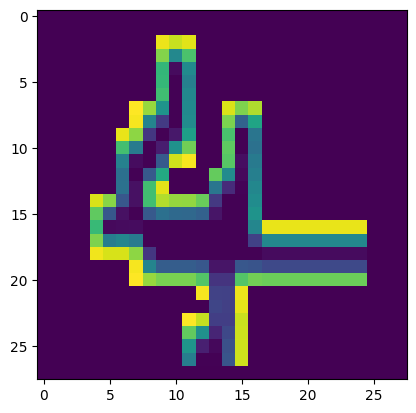

In [ ]:
print(label)
plt.imshow(img)
plt.imshow(img_1)
plt.show()

### match dtype

collected_data는 dtype이 float64, uint8이 두 개로 이루어져 있다. 하지만 작업에서는 uint8을 기준으로 하는게 더욱 편리하기 때문에 uint8로 맞춰준다.

In [ ]:
for i in range(len(original_data)):
    original_data[i] = match_dtype(original_data[i])

### 이상하게 생긴 1 데이터 삭제하기

1 데이터와 나머지 데이터를 나눈다.

In [ ]:
data_1 = []
data_else = []

for i in range(len(original_data)):
    img, label = original_data[i]
    img = np.reshape(img, (28,28,1))

    if label == 1:
        data_1.append((img, label))
    else:
        data_else.append((img, label))

1 데이터를 전부 출력해서, 육안으로 정상적인 데이터의 인덱스를 찾아낸다.

In [ ]:
for i in range(len(data_1)):
    img, label = data_1[i]
    img = np.squeeze(img)
    print(i)
    plt.imshow(img, cmap='gray')
    plt.show()

앞에서 찾아낸 데이터만 추출한다.

In [ ]:
normal_data_1 = np.array([data_1[i] for i in (0,1,2,3,4,5,6,7,14,20,22,23,24,27,29,32,33,34,35,37,40,41,43,46)], dtype='object')

이미지가 제대로 들어갔는지 확인하는 코드다.

In [ ]:
for i in range(len(normal_data_1)):
    img, label = normal_data_1[i]
    img = np.squeeze(img)
    print(i)
    plt.imshow(img, cmap='gray')
    plt.show()

total data에 솎아낸 1 데이터와 나머지 데이터를 전부 합친다. 굳이 섞을 이유는 없지만, 뭔가 기분이 나빠서 섞었다.

In [ ]:
total_data = np.concatenate([normal_data_1 ,data_else])
np.random.shuffle(total_data)

## 3 | Augmentation

### zoom

In [ ]:
zoomed_data = []

for data in total_data:
    zoom = ZoomAugmentor(data=data)
    zoom.run()
    zoomed_data.append((zoom.final_img, zoom.label))

In [ ]:
# 확인하는 코드
print_bothdata(total_data, zoomed_data)

### rotate

In [ ]:
rotated_data = []
zoom_rotated_data = []

for data in total_data:
    rotated_data.extend(rotate_img(data))

for data in zoomed_data:
    zoom_rotated_data.extend(rotate_img(data))


## 5 | Match type

In [ ]:
print(type(total_data))
print(type(zoomed_data))
print(type(rotated_data))
print(type(zoom_rotated_data))

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
<class 'list'>


In [ ]:
zoomed_data = np.array(zoomed_data, dtype=object)
rotated_data = np.array(rotated_data, dtype=object)
zoom_rotated_data = np.array(zoom_rotated_data, dtype=object)

### 6 | Check data info

In [ ]:
# shape must be (28,28,1)

print(total_data[0,0].shape)
print(zoomed_data[0,0].shape)
print(rotated_data[0,0].shape)
print(zoom_rotated_data[0,0].shape)

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


In [ ]:
#type must be np.array

print(type(total_data))
print(type(zoomed_data))
print(type(rotated_data))
print(type(zoom_rotated_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## 4 | Download

In [ ]:
with open('/content/drive/MyDrive/MNISTandCustom/datafile_02/collected_data.txt','wb') as f:
    pickle.dump(total_data,f)

with open('/content/drive/MyDrive/MNISTandCustom/datafile_02/zoomed_data.txt','wb') as f:
    pickle.dump(zoomed_data,f)

with open('/content/drive/MyDrive/MNISTandCustom/datafile_02/rotated_data.txt','wb') as f:
    pickle.dump(rotated_data,f)

with open('/content/drive/MyDrive/MNISTandCustom/datafile_02/zoom_rotated_data.txt','wb') as f:
    pickle.dump(zoom_rotated_data,f)

문제 상황 : 어떤 데이터는 0-1사이, 어떤거는 255 사이
이유는 모르겠는데 뭐 ... 내가 중간에 코드를 바꿨겠지